# Preprocesado del dataset

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

## Importar el dataset

In [2]:
positive_dir = Path('/content/drive/MyDrive/Especializacion Inteligencia Artificial y Big Data/Sistemas de Aprendizaje/DatasetCNN/Positive')
negative_dir = Path('/content/drive/MyDrive/Especializacion Inteligencia Artificial y Big Data/Sistemas de Aprendizaje/DatasetCNN/Negative')

In [3]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [4]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,/content/drive/MyDrive/Especializacion Intelig...,NEGATIVE
1,/content/drive/MyDrive/Especializacion Intelig...,POSITIVE
2,/content/drive/MyDrive/Especializacion Intelig...,NEGATIVE
3,/content/drive/MyDrive/Especializacion Intelig...,POSITIVE
4,/content/drive/MyDrive/Especializacion Intelig...,POSITIVE
...,...,...
4037,/content/drive/MyDrive/Especializacion Intelig...,NEGATIVE
4038,/content/drive/MyDrive/Especializacion Intelig...,POSITIVE
4039,/content/drive/MyDrive/Especializacion Intelig...,NEGATIVE
4040,/content/drive/MyDrive/Especializacion Intelig...,POSITIVE


## Separación en entrenamiento y test

In [5]:
train_df, test_df = train_test_split(
    all_df.sample(1000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

# Creación de la Red Neuronal Convolucional

En este caso he decidido probar con dos versiones distintas del mismo modelo, mismas capas, mismas neuronas, pero con diferencia de que en uno de ellos utilizo capas Conv2D y en otro, capas SeparableConv2D.

La principal diferencia entre estas dos capas debería ser la velocidad de entrenamiento, encontraremos valores de loss y accuracy muy parecidos entre ambos módelos, aunque un tiempo de entrenamiento mucho más reducido para el modelo que incluya capas SeparableConv2D

In [6]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [7]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 560 validated image filenames belonging to 2 classes.
Found 140 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


(32, 120, 120, 3)


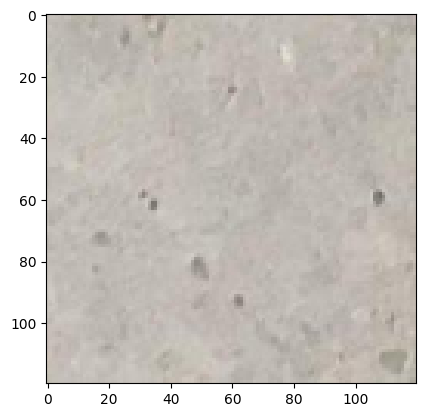

(32, 120, 120, 3)


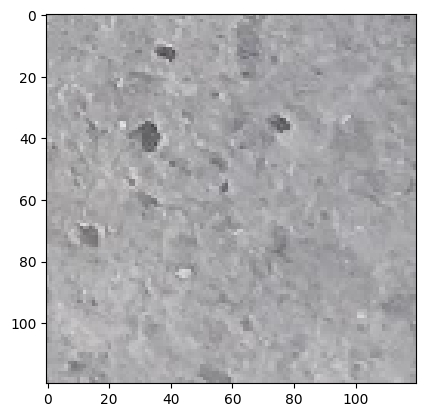

(32, 120, 120, 3)


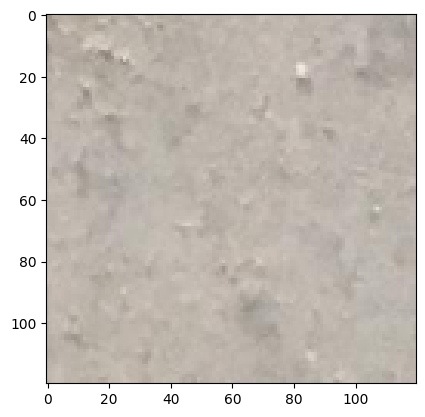

(32, 120, 120, 3)


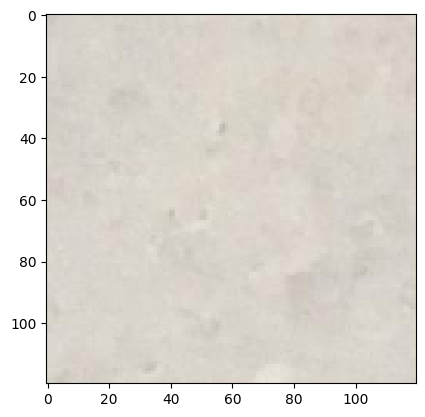

(32, 120, 120, 3)


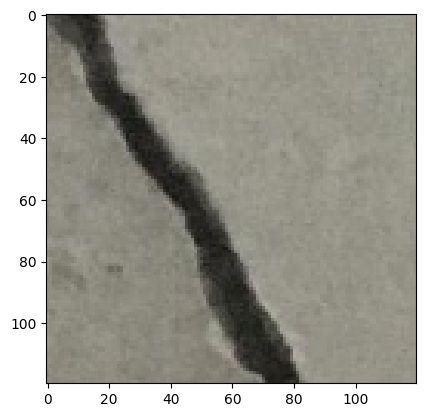

(32, 120, 120, 3)


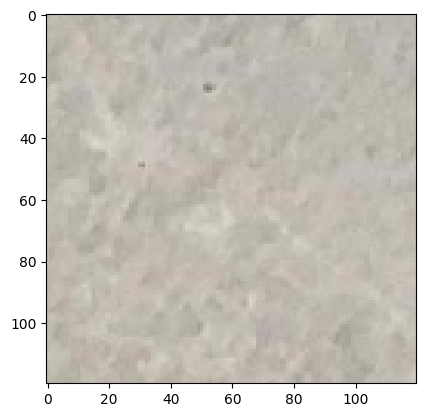

(32, 120, 120, 3)


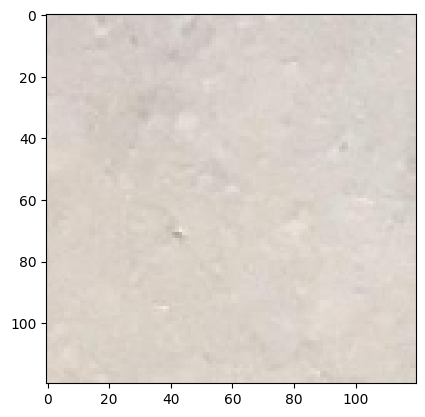

(32, 120, 120, 3)


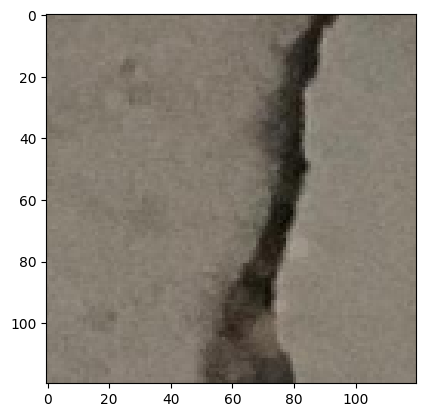

(32, 120, 120, 3)


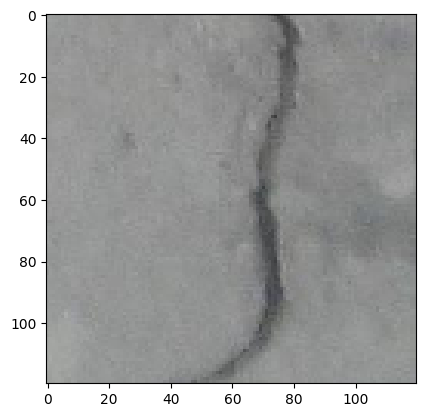

(32, 120, 120, 3)


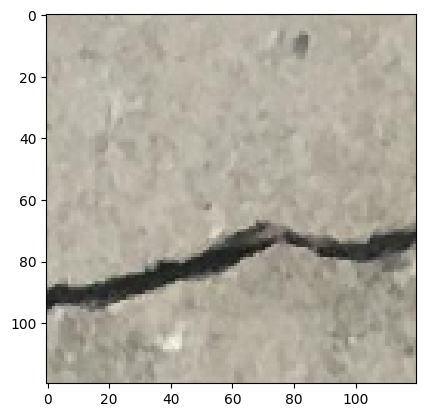

In [8]:
for _ in range(10):
    img, label = train_data.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [9]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 32)        0         
 g2D)                                                            
                                                                 
 global_average_pooling2d (  (None, 32)                0     

In [10]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.SeparableConv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_separable = tf.keras.Model(inputs=inputs, outputs=outputs)

model_separable.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model_separable.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 separable_conv2d (Separabl  (None, 118, 118, 16)      91        
 eConv2D)                                                        
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 59, 59, 16)        0         
 g2D)                                                            
                                                                 
 separable_conv2d_1 (Separa  (None, 57, 57, 32)        688       
 bleConv2D)                                                      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 28, 28, 32)        0         
 g2D)                                                      

# Entrenamiento del modelo

In [11]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
18/18 [==============================] - 84s 4s/step - loss: 0.6953 - accuracy: 0.5321 - val_loss: 0.6908 - val_accuracy: 0.4143
Epoch 2/50
18/18 [==============================] - 3s 172ms/step - loss: 0.6855 - accuracy: 0.5482 - val_loss: 0.7031 - val_accuracy: 0.4143
Epoch 3/50
18/18 [==============================] - 3s 147ms/step - loss: 0.6776 - accuracy: 0.6286 - val_loss: 0.6904 - val_accuracy: 0.4143
Epoch 4/50
18/18 [==============================] - 3s 141ms/step - loss: 0.6588 - accuracy: 0.6786 - val_loss: 0.6554 - val_accuracy: 0.7071
Epoch 5/50
18/18 [==============================] - 3s 148ms/step - loss: 0.6421 - accuracy: 0.6625 - val_loss: 0.6164 - val_accuracy: 0.6143
Epoch 6/50
18/18 [==============================] - 3s 141ms/step - loss: 0.6334 - accuracy: 0.6446 - val_loss: 0.5963 - val_accuracy: 0.7786
Epoch 7/50
18/18 [==============================] - 3s 171ms/step - loss: 0.5975 - accuracy: 0.7464 - val_loss: 0.5695 - val_accuracy: 0.8357
Epoch 8/

In [12]:
history_separable = model_separable.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
18/18 [==============================] - 6s 163ms/step - loss: 0.6948 - accuracy: 0.5321 - val_loss: 0.7030 - val_accuracy: 0.4143
Epoch 2/50
18/18 [==============================] - 3s 146ms/step - loss: 0.6933 - accuracy: 0.5321 - val_loss: 0.7038 - val_accuracy: 0.4143
Epoch 3/50
18/18 [==============================] - 3s 140ms/step - loss: 0.6915 - accuracy: 0.5321 - val_loss: 0.6997 - val_accuracy: 0.4143
Epoch 4/50
18/18 [==============================] - 3s 141ms/step - loss: 0.6867 - accuracy: 0.5321 - val_loss: 0.7012 - val_accuracy: 0.4143
Epoch 5/50
18/18 [==============================] - 3s 163ms/step - loss: 0.6844 - accuracy: 0.5321 - val_loss: 0.6959 - val_accuracy: 0.4143
Epoch 6/50
18/18 [==============================] - 3s 141ms/step - loss: 0.6792 - accuracy: 0.5321 - val_loss: 0.6945 - val_accuracy: 0.4143
Epoch 7/50
18/18 [==============================] - 2s 137ms/step - loss: 0.6721 - accuracy: 0.5321 - val_loss: 0.6956 - val_accuracy: 0.4143
Epoch 

# Evaluación del modelo durante el entrenamiento

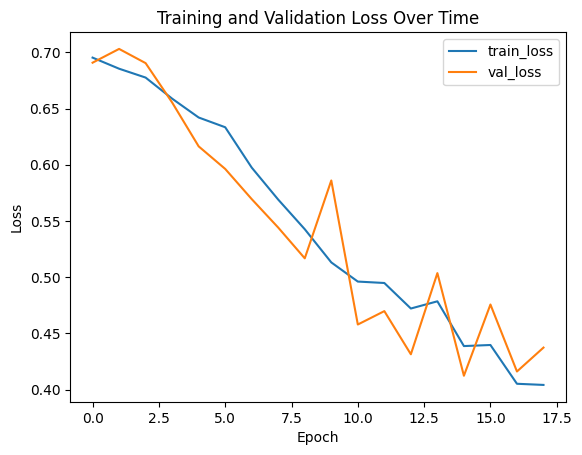

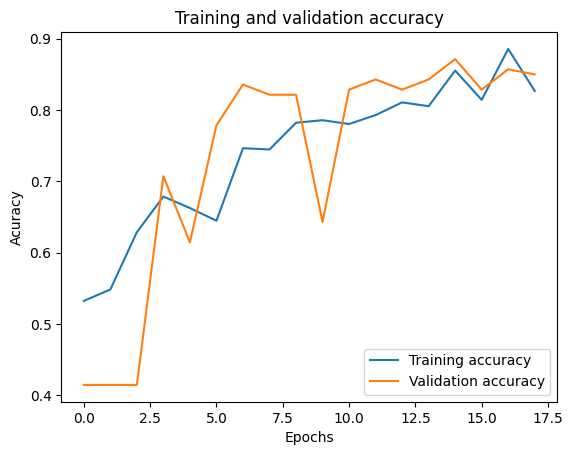

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acuracy')
plt.legend()
plt.show()

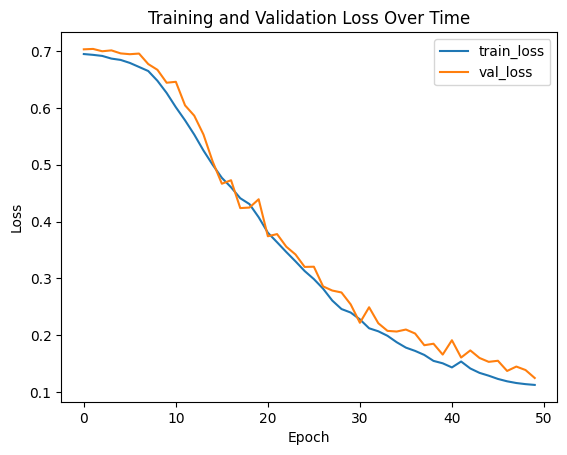

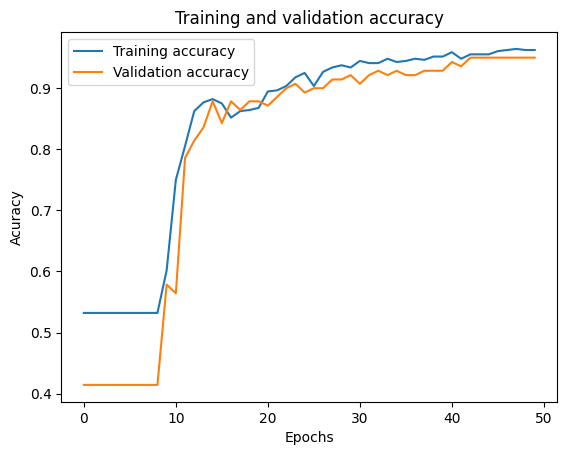

In [14]:
plt.plot(history_separable.history['loss'])
plt.plot(history_separable.history['val_loss'])
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history_separable.history['accuracy'], label='Training accuracy')
plt.plot(history_separable.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acuracy')
plt.legend()
plt.show()

# Utilizar el modelo para predecir nuevos valores

In [15]:
number_img = train_gen[7,:,:,0]
print(number_img.shape)
plt.imshow(number_img, cmap='Greys')

for _ in range(10):
    img, label = train_data.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

# however, predict method takes as input a 4D array (samples,height,width,ch),
# so you have to select a slice of (just one) images (hence the 7:8 instead of 7)
prediction = model.predict(train_gen[7:8,:,:,:])
print(prediction)

TypeError: 'ImageDataGenerator' object is not subscriptable

In [ ]:
train_data

# Analizar métricas

In [16]:
def evaluate_model(model, test_data):

    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]

    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))

    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int32))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Matriz de confusión")
    plt.show()

    print("Classification Report:\n----------------------\n", clr)

    Test Loss: 0.42980
Test Accuracy: 86.00%
10/10 [==============================] - 1s 102ms/step


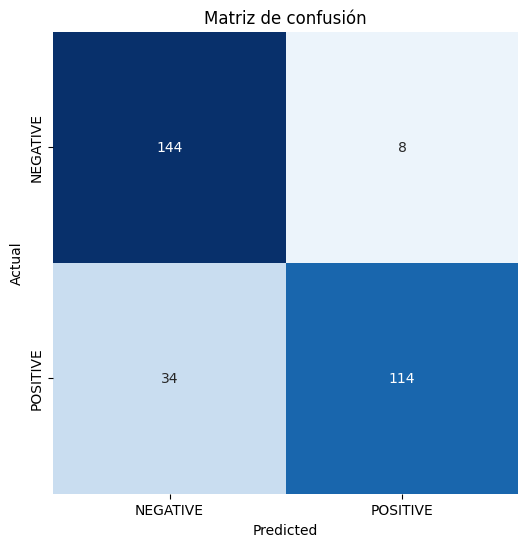

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.81      0.95      0.87       152
    POSITIVE       0.93      0.77      0.84       148

    accuracy                           0.86       300
   macro avg       0.87      0.86      0.86       300
weighted avg       0.87      0.86      0.86       300



In [17]:
evaluate_model(model, test_data)

    Test Loss: 0.26558
Test Accuracy: 94.67%
10/10 [==============================] - 1s 119ms/step


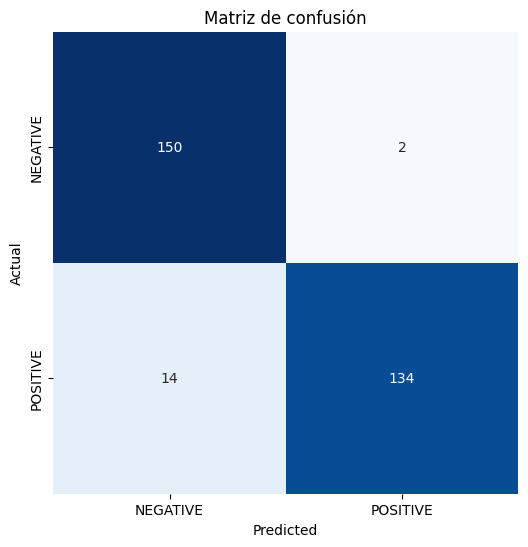

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.91      0.99      0.95       152
    POSITIVE       0.99      0.91      0.94       148

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



In [18]:
evaluate_model(model_separable, test_data)

Observamos que el modelo separable tiene un desempeño considerablemente mejor que el modelo que no lo utiliza